In [223]:
import matplotlib.pyplot as plt
import numpy as np

### Краевая задача (метод конечных разностей)

## Краевые задачи

### Всякая всячина

Класс для отображения функций

In [224]:
class LabeledFunValue:
    def __init__(self, x, y, label):
        self.x = x
        self.y = y
        self.label = label

Функция выбора стилей графиков для n функций

In [225]:
def generate_line_styles(num_functions):
    line_styles = ['-', '--', '-.', ':']
    styles = []

    for i in range(num_functions):
        style = line_styles[i % len(line_styles)]
        styles.append(style)

    return styles

Функция визуализации функций 😄

In [226]:
def visualize_funs(title: str, *fun_value: LabeledFunValue):
    line_styles = generate_line_styles(len(fun_value))

    for i, fun in enumerate(fun_value):
        plt.plot(fun.x, fun.y, line_styles[i], label=fun.label)
        plt.xlabel('x')
        plt.ylabel('y(x)')
        plt.title(title)
        plt.grid(True)
        plt.legend()

    plt.show()

Метод прогонки

In [227]:
def thomas_algorithm(a, b, c, d):
    n = len(d)
    c_ = np.zeros(n)
    d_ = np.zeros(n)
    x = np.zeros(n)

    c_[0] = c[0] / b[0]
    d_[0] = d[0] / b[0]
    for i in range(1, n):
        denom = b[i] - a[i - 1] * c_[i - 1]
        c_[i] = c[i] / denom if i < n - 1 else 0
        d_[i] = (d[i] - a[i - 1] * d_[i - 1]) / denom

    x[-1] = d_[-1]
    for i in range(n - 2, -1, -1):
        x[i] = d_[i] - c_[i] * x[i + 1]

    return x

Тестируем функцию метода прогонки

In [228]:
def test_thomas():
    A = np.array([
        [2, 1, 0, 0],
        [1, 2, 1, 0],
        [0, 1, 2, 1],
        [0, 0, 1, 2]
    ])

    x_true = np.array([1, 2, 3, 4])
    b = A @ x_true

    a = np.diag(A, k=-1)
    c = np.diag(A, k=1)
    d = b
    b_main = np.diag(A)

    x_sol = thomas_algorithm(a, b_main, c, d)

    print("Истинное решение:", x_true)
    print("Решение методом Томаса:", x_sol)
    print("Ошибка:", np.linalg.norm(x_true - x_sol))

    assert np.allclose(x_true, x_sol, atol=1e-8), "Тест не пройден!"
    print("✅ Тест пройден успешно!")


test_thomas()

Истинное решение: [1 2 3 4]
Решение методом Томаса: [1. 2. 3. 4.]
Ошибка: 1.6011864169946884e-15
✅ Тест пройден успешно!


### Задание 1

In [229]:
'''
    y'' + p(x)y' + q(x)y = f(x);
    y(lb) = 0;
    y(rb) = 1;

    lb - левая граница по x
    rb - правая граница по x
'''
def solve_dirichlet(p, q, f, lb=0.0, rb=1.0, N=10):
    L = rb - lb
    h = L / N
    x = np.linspace(lb, rb, N + 1)

    a = np.zeros(N - 1)
    b = np.zeros(N - 1)
    c = np.zeros(N - 1)
    d = np.vectorize(f)(x)

    for i in range(1, N):
        xi = x[i]
        a[i - 1] = 1 / h ** 2 - p(xi) / (2 * h)
        b[i - 1] = -2 / h ** 2 + q(xi)
        c[i - 1] = 1 / h ** 2 + p(xi) / (2 * h)

        if i == 1:
            d[i - 1] -= a[i - 1] * lb
        if i == N - 1:
            d[i - 1] -= c[i - 1] * rb

    y_inner = thomas_algorithm(a, b, c, d[0:N - 1])

    # Собираем полный вектор y
    y = np.zeros(N + 1)
    y[0] = lb
    y[1:N] = y_inner
    y[N] = rb

    return x, y

Задаем условия задачи

In [230]:
p = lambda x: x
q = lambda x: -2
f = lambda x: 2
exact_fun = lambda x: x ** 2
lb = 0.0
rb = 1.0

x = 0.000, y ~ 0.000000
x = 0.100, y ~ 0.011837
x = 0.200, y ~ 0.043693
x = 0.300, y ~ 0.095526
x = 0.400, y ~ 0.167199
x = 0.500, y ~ 0.258479
x = 0.600, y ~ 0.369047
x = 0.700, y ~ 0.498502
x = 0.800, y ~ 0.646376
x = 0.900, y ~ 0.812139
x = 1.000, y ~ 1.000000


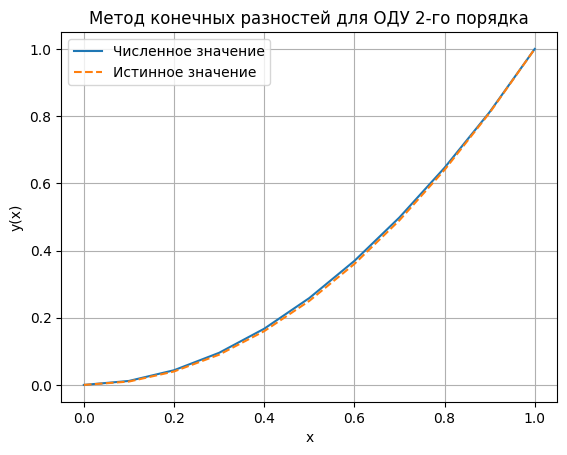

In [231]:
N = 10

x, y = solve_dirichlet(p, q, f, lb, rb, N)

for xi, yi in zip(x, y):
    print(f"x = {xi:.3f}, y ~ {yi:.6f}")

y_t = exact_fun(x)

visualize_funs('Метод конечных разностей для ОДУ 2-го порядка',
               LabeledFunValue(x, y, 'Численное значение'),
               LabeledFunValue(x, y_t, 'Истинное значение'))

### Задание 2

In [232]:
'''
    y''+p(x)y'+q(x)y = f(x);
    y(lb) = bb;
    dp*y(rb) + dq*y'(rb) = tb;
'''
def solve_bvp(p, q, f, lb, rb, tb, bb, dp, dq, N=10):
    n = N + 1
    L = rb - lb
    h = L / N
    x = np.linspace(lb, rb, n)

    # Матрица и правая часть
    a = np.zeros(n)
    b = np.zeros(n)
    c = np.zeros(n)
    d = np.zeros(n)

    b[0] = -1.0
    c[0] = 1.0
    d[0] = bb * h

    for i in range(1, N):
        xi = x[i]
        a[i] = 1 / h ** 2 - p(xi) / (2 * h)
        b[i] = -2 / h ** 2 + q(xi)
        c[i] = 1 / h ** 2 + p(xi) / (2 * h)
        d[i] = f(xi)

    a[-1] = -dq / h
    b[-1] = dp + dq / h
    d[-1] = tb

    # Решаем СЛАУ
    y = thomas_algorithm(a[1:], b, c[:-1], d)

    return x, y

In [233]:
# p, q, f, lb, rb, tb, bb, dp, dq, N=10

p = lambda x: -0.5
q = lambda x: 0.5 * x
f = lambda x: 2 * x

lb = 1
rb = 1.3

tb = 2
bb = 0.5

dp = 2
dq = -1

In [234]:
# p, q, f, lb, rb, tb, bb, dp, dq, N=10

p = lambda x: 0.8
q = lambda x: -x
f = lambda x: 1.4

lb = 1.8
rb = 2.1

tb = 1.7
bb = 0.5

dp = 2
dq = 1

In [235]:
# p, q, f, lb, rb, tb, bb, dp, dq, N=10

p = lambda x: 2 * x
q = lambda _: -2
f = lambda _: 0.6

lb = 2.0
rb = 2.3

tb = 1
bb = 1

dp = 0.4
dq = -1

Отображаем на плоскости

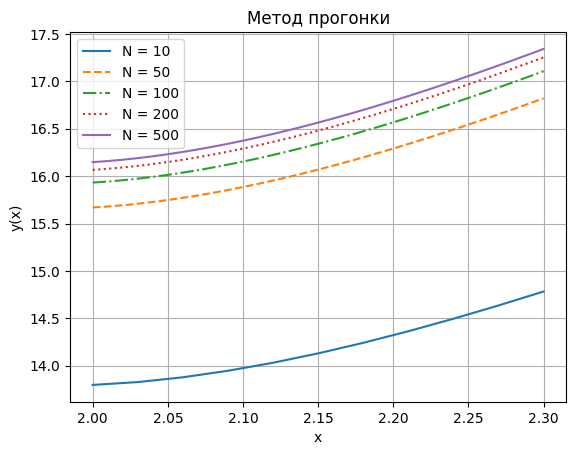

In [236]:
n_list = [10, 50, 100, 200, 500]
fun_list: list[LabeledFunValue] = []

for n in n_list:
    x, y = solve_bvp(p, q, f, lb, rb, tb, bb, dp, dq, n)

    fun_list.append(LabeledFunValue(x, y, f'N = {n}'))

visualize_funs('Метод прогонки', *fun_list)

### Задание 3

In [237]:
def differentiate(f, dx=1e-6):
    return lambda x: (f(x + dx) - f(x - dx)) / (2 * dx)

In [238]:
def gauss_integrate(func, a, b, n=5):
    xg, wg = np.polynomial.legendre.leggauss(n)
    x_mapped = 0.5 * (xg + 1) * (b - a) + a
    return 0.5 * (b - a) * np.sum(wg * func(x_mapped))

In [239]:
def solve_galerkin_n3(x0, xn,
                      p, q, f,
                      bb, dp, dq, tb):
    A = bb
    B = (tb - dp * bb * xn - dq * bb) / dp

    def y0(x):
        return A * x + B

    def dy0(x):
        return A

    # Проверка граничных условий для y0
    tol = 1e-8
    assert np.isclose(dy0(x0), bb, atol=tol), "y0'(x0) != t"
    assert np.isclose(dp * y0(xn) + dq * dy0(xn), tb, atol=tol), "dp*y0(xn) + dq*y0'(xn) != b"

    # 2) Базисные функции phi1, phi2, phi3
    phi = [
        lambda x: (x - x0) ** 2 * (x - xn) ** 2,
        lambda x: (x - x0) ** 2 * (x - xn) ** 2 * (x - (xn + x0) / 2),
        lambda x: (x - x0) ** 2 * (x - xn) ** 2 * (x - (xn + x0) / 2) ** 2
    ]

    dphi = [differentiate(fn) for fn in phi]
    ddphi = [differentiate(fn) for fn in dphi]

    # Проверка граничных условий
    tol = 1e-8
    for i in range(len(phi)):
        assert np.isclose(dphi[i](x0), 0.0, atol=tol), f"Базисные функции не удовлетворяют граничным условиям"
        assert np.isclose(dp * phi[i](xn) + dq * dphi[i](xn), 0.0,
                          atol=tol), f"Базисные функции не удовлетворяют граничным условиям"

    # 3) Сборка матрицы и правой части
    n = len(phi)
    A_mat = np.zeros((n, n))
    L_vec = np.zeros(n)

    for i in range(n):
        for j in range(n):
            integrand_A = lambda x: (
                    ddphi[j](x) * phi[i](x) +
                    p(x) * dphi[j](x) * phi[i](x) +
                    q(x) * phi[j](x) * phi[i](x)
            )
            A_mat[i, j] = gauss_integrate(integrand_A, x0, xn)

        integrand_L = lambda x: (
                f(x) * phi[i](x) -
                (ddphi[i](x) * y0(x) + p(x) * dphi[i](x) * dy0(x) + q(x) * y0(x) * phi[i](x))
        )
        L_vec[i] = gauss_integrate(integrand_L, x0, xn)

    alpha = np.linalg.solve(A_mat, L_vec)

    def y_h(x):
        return y0(x) + sum(alpha[i] * phi[i](x) for i in range(n))

    return y_h, alpha

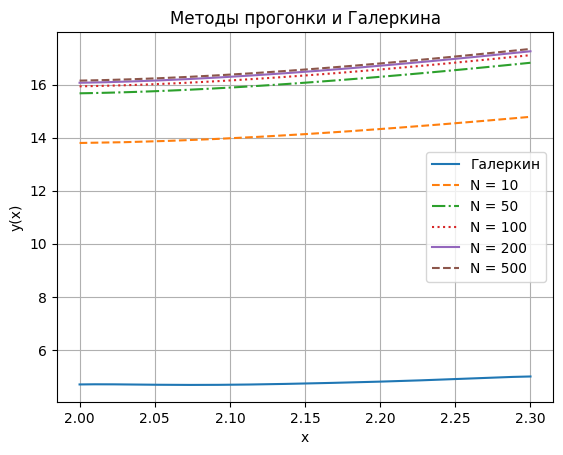

In [240]:
# Метод Галеркина
y_h, coeffs = solve_galerkin_n3(
    x0=lb, xn=rb,
    p=p, q=q, f=f,
    bb=bb, dp=dp, dq=dq, tb=tb
)
xs = np.linspace(lb, rb, 1000)

y_val_h = y_h(xs)

# отображаем Галеркина и метод прогонки из задания 2
visualize_funs('Методы прогонки и Галеркина',
               LabeledFunValue(xs, y_val_h, 'Галеркин'),
               *fun_list)
